In [1]:
import numpy as np
import pandas as pd
from plotnine import *

In [2]:
df = pd.read_table("../data/galton.txt")
df = (df
 .assign(parent = 0.5 * (df["Father"] + df["Mother"]))
 .rename(columns={"Height": "child height", "parent": "average parent height"}))

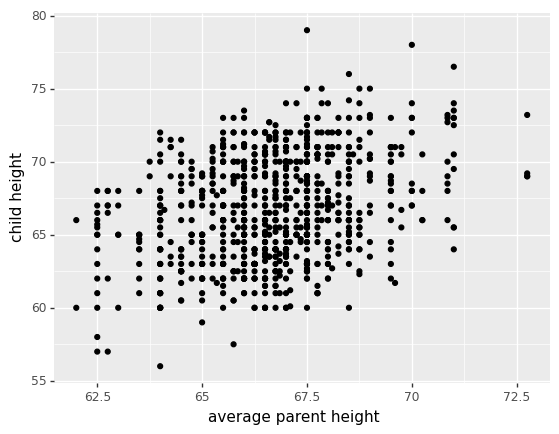

<ggplot: (341372297)>

In [3]:
g = (ggplot(df, aes('average parent height', 'child height')) +
 geom_point())
g

In [34]:
g.save(filename = '../figures/galton_raw.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_raw.pdf


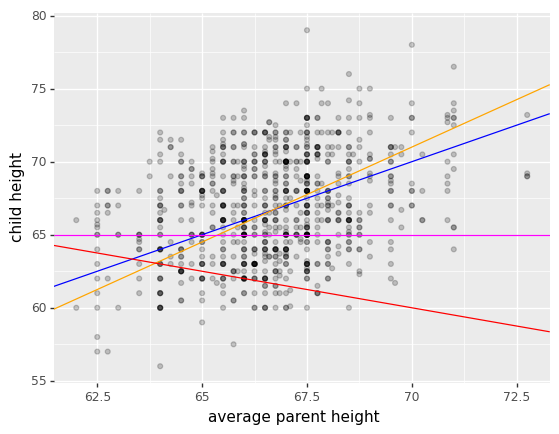

<ggplot: (351584925)>

In [65]:
g = (ggplot(df, aes('average parent height', 'child height')) +
 geom_point(alpha=0.2) +
 geom_abline(colour="blue") +
 geom_abline(slope=1.3, intercept=-20, colour="orange") +
 geom_abline(slope=0, intercept=65, colour="magenta") +
 geom_abline(slope=-0.5, intercept=95, colour="red"))
g

In [66]:
g.save(filename = '../figures/galton_example_lines.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_example_lines.pdf


# Fake data

In [87]:
df1 = pd.DataFrame({'child height' : [60, 65, 70, 75, 80],
                    'average parent height' : [63, 60, 72, 74, 79]})

In [88]:
g = (ggplot(df1, aes('average parent height', 'child height')) +
 geom_point(alpha=1) +
 geom_abline(colour="blue"))

In [89]:
g.save(filename = '../figures/galton_model_without_residuals.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_model_without_residuals.pdf


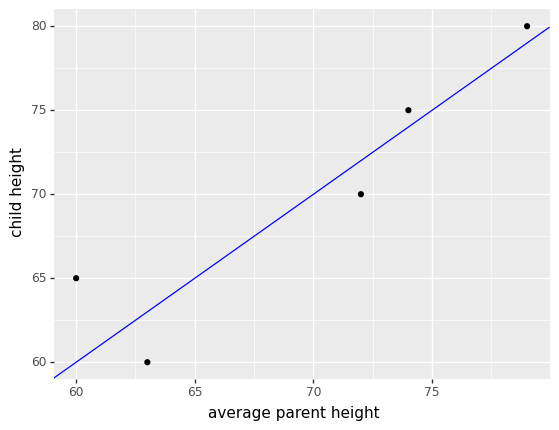

<ggplot: (351270565)>

In [90]:
g

In [93]:
g = (ggplot(df1, aes('average parent height', 'child height')) +
 geom_point(alpha=1) +
 geom_abline(colour="blue") +
 annotate("segment", x = 60, xend = 60, y = 60, yend = 65, colour = "orange", size=0.5, alpha=1, arrow=arrow()) +
 annotate("segment", x = 63, xend = 63, y = 63, yend = 60, colour = "orange", size=0.5, alpha=1, arrow=arrow()) +
 annotate("segment", x = 72, xend = 72, y = 72, yend = 70, colour = "orange", size=0.5, alpha=1, arrow=arrow()) +
 annotate("segment", x = 74, xend = 74, y = 74, yend = 75, colour = "orange", size=0.5, alpha=1, arrow=arrow()) +
 annotate("segment", x = 79, xend = 79, y = 79, yend = 80, colour = "orange", size=0.5, alpha=1, arrow=arrow())
)

In [94]:
g.save(filename = '../figures/galton_model_with_residuals.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_model_with_residuals.pdf


# Fitting

In [34]:
def error_abs(params):
    a = params[0]
    b = params[1]
    y = a + b * df["average parent height"]
    return np.mean(np.abs(y - df["child height"]))
def error_quad(params):
    a = params[0]
    b = params[1]
    y = a + b * df["average parent height"]
    return np.mean((y - df["child height"])**4)
def error_square(params):
    a = params[0]
    b = params[1]
    y = a + b * df["average parent height"]
    return np.mean((y - df["child height"])**2)

Try multistart optimisation.

In [35]:
import scipy.optimize as optimize
import scipy.stats
def optimise_random(ntries):
    min_dist = 1000
    for i in range(ntries):
        a_init = scipy.stats.norm.rvs(15, 10, 1)[0]
        b_init = scipy.stats.norm.rvs(1, 1, 1)[0]
        initial_guess = [a_init, b_init]
        result = optimize.minimize(error_abs, initial_guess, method='CG')
        fun = result['fun']
        if fun < min_dist:
            min_dist = fun
            params = result['x']
            a = params[0]
            b = params[1]
    return a, b
a, b = optimise_random(10)

In [36]:
initial_guess = [15, 1]
result = optimize.minimize(error_quad, initial_guess, method='CG')
params = result['x']
a1 = params[0]
b1 = params[1]
print(a1, b1)
result = optimize.minimize(error_square, initial_guess, method='CG')
params = result['x']
a2 = params[0]
b2 = params[1]
print(a2, b2)

17.975741564277175 0.7328831013941336
22.149257546791954 0.6692521657875752


In [37]:
a, b

(26.544169713341727, 0.5993690025444038)

In [38]:
df1 = (df
      .assign(absolute = a + b * df["average parent height"])
      .assign(fourth = a1 + b1 * df["average parent height"])
      .assign(square = a2 + b2 * df["average parent height"]))
df1 = df1[["average parent height", "child height", "absolute", "square", "fourth"]]
df1 = pd.melt(df1, id_vars="average parent height")

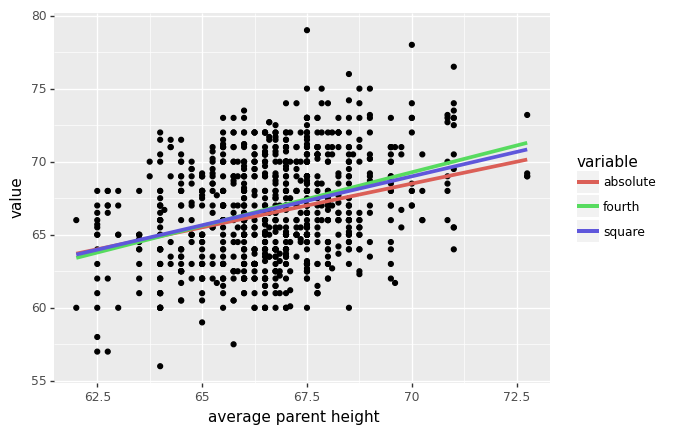

<ggplot: (344100773)>

In [39]:
df_actual = df1.query('variable == "child height"')
df_fits = df1.query('variable != "child height"')
g = (ggplot(df_actual, aes('average parent height', 'value')) +
 geom_point() +
 geom_line(df_fits, aes(colour='variable'), size=1.5))
g

In [213]:
g.save(filename = '../figures/galton_fits_all.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_fits_all.pdf


In [40]:
df_actual = df1.query('variable == "child height"')
df_fits = df1.query('variable == "square"')
g = (ggplot(df_actual, aes('average parent height', 'value')) +
 geom_point() +
 geom_line(df_fits, colour="blue", size=1.5))
g
g.save(filename = '../figures/galton_fit_sse.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_fit_sse.pdf


/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_regression_to_mean.pdf


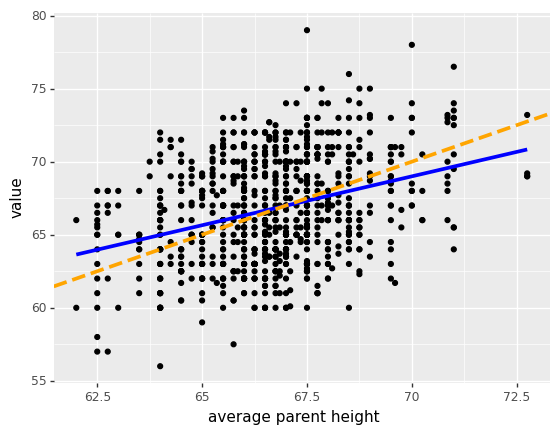

<ggplot: (344540885)>

In [47]:
g = (ggplot(df_actual, aes('average parent height', 'value')) +
 geom_point() +
 geom_line(df_fits, colour="blue", size=1.5) +
 geom_abline(linetype='dashed', colour='orange', size=1.5))
g.save(filename = '../figures/galton_regression_to_mean.pdf')
g

# Linearity

In [21]:
df1 = (df
      .assign(absolute = a + b * df["average parent height"])
      .assign(fourth = a1 + b1 * df["average parent height"])
      .assign(square = a2 + b2 * df["average parent height"]))
df1 = (df1
      .assign(error = df1["square"] - df["child height"]))
df1 = (df1
      .assign(error_sq=df1["error"]**2))

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_linearity.pdf
/usr/local/lib/python3.7/site-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/usr/local/lib/python3.7/site-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


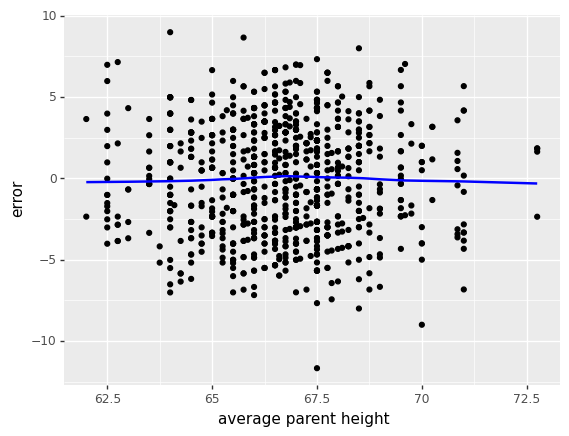

<ggplot: (344059245)>

In [29]:
g = (ggplot(df1, aes('average parent height', 'error')) +
geom_point() +
geom_smooth(colour='blue'))
g.save(filename = '../figures/galton_linearity.pdf')
g

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_variance.pdf
/usr/local/lib/python3.7/site-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/usr/local/lib/python3.7/site-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


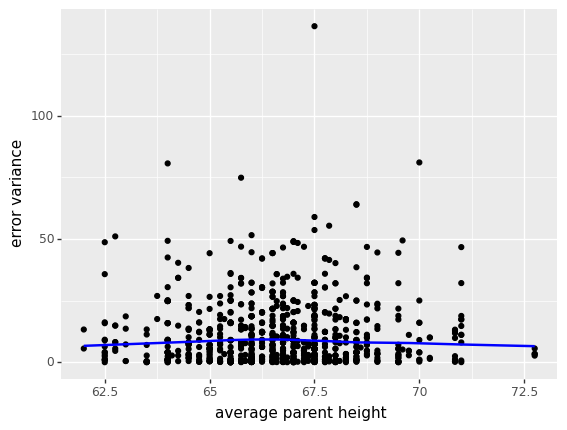

<ggplot: (344400745)>

In [31]:
g = (ggplot(df1, aes('average parent height', 'error_sq')) +
geom_point() +
geom_smooth(colour='blue') +
ylab("error variance"))
g.save(filename = '../figures/galton_variance.pdf')
g

# Bootstrap sampling

In [77]:
def bootstrap_plot(df):
    df_temp = df.sample(n=len(df), replace=True)
    g = (ggplot(df_temp, aes('average parent height', 'child height')) +
     geom_point() +
     geom_smooth(method='lm', se=False, colour='blue'))
    return df_temp, g

In [78]:
a = []
b = []
for i in range(4):
    df_temp, g = bootstrap_plot(df)
    def error_square(params):
        a = params[0]
        b = params[1]
        y = a + b * df_temp["average parent height"]
        return np.mean((y - df_temp["child height"])**2)
    result = optimize.minimize(error_square, initial_guess, method='CG')
    params = result['x']
    a_temp = params[0]
    b_temp = params[1]
    a.append(a_temp)
    b.append(b_temp)
    g.save('../figures/galton_' + str(i) + '.pdf')

/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_0.pdf
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_1.pdf
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_2.pdf
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_3.pdf


/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../figures/galton_bootstrapped_estimates.pdf


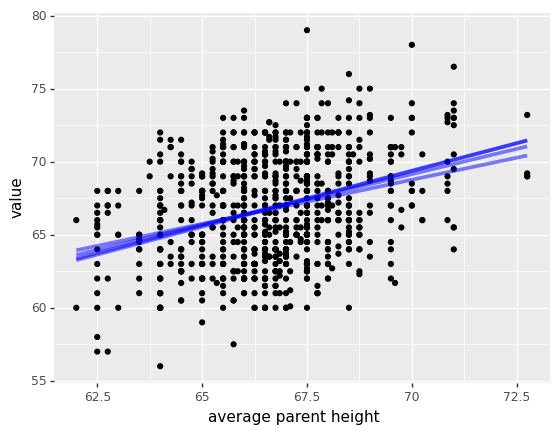

<ggplot: (348194277)>

In [79]:
df1 = (df
      .assign(model_1 = a[0] + b[0] * df["average parent height"])
      .assign(model_2 = a[1] + b[1] * df["average parent height"])
      .assign(model_3 = a[2] + b[2] * df["average parent height"])
      .assign(model_4 = a[3] + b[3] * df["average parent height"]))
df1 = df1[["average parent height", "child height",
           "model_1", "model_2", "model_3", "model_4"]]
df1 = pd.melt(df1, id_vars="average parent height")
df_actual = df1.query('variable == "child height"')
df_fits = df1.query('variable != "child height"')
g = (ggplot(df_actual, aes('average parent height', 'value')) +
 geom_point() +
 geom_line(df_fits, aes(group='variable'), size=1.5, colour='blue', alpha=0.5))
g.save('../figures/galton_bootstrapped_estimates.pdf')
g

In [80]:
nreplicates = 100
a = []
b = []
for i in range(nreplicates):
    df_temp = df.sample(n=len(df), replace=True)
    def error_square(params):
        a = params[0]
        b = params[1]
        y = a + b * df_temp["average parent height"]
        return np.mean((y - df_temp["child height"])**2)
    result = optimize.minimize(error_square, initial_guess, method='CG')
    params = result['x']
    a_temp = params[0]
    b_temp = params[1]
    a.append(a_temp)
    b.append(b_temp)

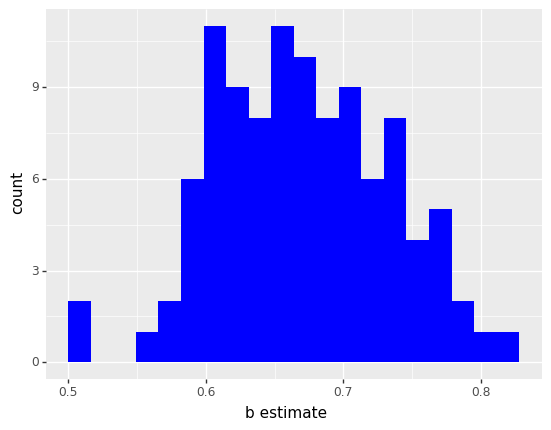

<ggplot: (347542389)>

In [88]:
df_estimates = pd.DataFrame({'b': b})
g = (ggplot(df_estimates, aes('b')) +
geom_histogram(fill='blue', bins=20) +
xlab('b estimate'))
g.save('../figures/galton_bootstrapped_estimates_histogram.pdf')
g